In [1]:
import sys
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import torchvision
from PIL import Image
import numpy as np
import SimpleITK as sitk
import radiomics as rad
import six
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib

%load_ext autoreload
%autoreload 2

plt.rcParams.update({"axes.facecolor" : "white",
                     "axes.edgecolor":  "black",
                     "patch.facecolor": "white",
                     "figure.facecolor" : "white"}) # prevent the transparency 
sns.set_theme(style="whitegrid", font_scale=1.55)


In [2]:
sys.path.append(os.path.abspath('src/'))
from data.lungdataset import LungData

In [3]:
#from utils import extract_firstlevel_features
rootdir = "/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh1_A"
ld = LungData(rootdir)
medical_df = ld.raw_ehd
ehd = ld.process_features(return_df=True)
image_df = ld.as_dataframe()
#ld.as_dataframe()

print(medical_df.shape, "---", ehd.shape)

(1279, 130) --- (1279, 78)


In [4]:
rdf = pd.read_csv("data/radiomics/thresh1_radiomics_all_stacked.csv")
rdf = ld.prepare_multiclass_for_radiomics(rdf, medical_df, verbose=False)
rdf.head(5)

,10Percentile_l,90Percentile_l,Energy_l,Entropy_l,InterquartileRange_l,Kurtosis_l,Maximum_l,MeanAbsoluteDeviation_l,Mean_l,Median_l,...,HighGrayLevelEmphasis_r,LargeDependenceEmphasis_r,LargeDependenceHighGrayLevelEmphasis_r,LargeDependenceLowGrayLevelEmphasis_r,LowGrayLevelEmphasis_r,SmallDependenceEmphasis_r,SmallDependenceHighGrayLevelEmphasis_r,SmallDependenceLowGrayLevelEmphasis_r,id,y
0,71.0,150.0,394369086.0,2.394008,41.0,3.095117,218.0,24.855771,113.581023,116.0,...,20.869773,41.678136,840.518399,4.847234,0.110090,0.056541,1.328324,0.005729,A860070,3
1,55.0,149.0,296824858.0,2.539965,50.0,2.468845,194.0,28.485066,104.368473,107.0,...,22.867574,42.255443,937.161292,3.852431,0.087336,0.059224,1.406542,0.005033,A860070,3
2,54.0,161.0,707815625.0,2.702847,57.0,2.444984,211.0,32.624710,111.785194,116.0,...,2.507463,38.208955,86.283582,26.256633,0.639718,0.057139,0.151222,0.037764,A860070,3
3,64.0,155.0,426125614.0,2.510545,48.0,2.926102,215.0,28.382876,115.519975,122.0,...,24.524862,37.920871,942.892160,3.744262,0.094085,0.058552,1.440691,0.005426,A860070,3
4,77.0,171.0,480829393.0,2.587292,51.0,3.016582,224.0,30.056974,129.213178,136.0,...,32.925355,39.206941,1364.961341,2.504407,0.067633,0.058938,1.848536,0.004401,A860070,3


In [5]:
scaler = StandardScaler()
rdfs = scaler.fit_transform(rdf.drop(["id", "y", "xray_path"], axis=1))
rdfs = pd.DataFrame(rdfs, columns = rdf.drop(["id", "y", "xray_path"], axis=1).columns)
#rdfs["left"] = rdf["left"].astype(int)
rdfs.head(5)

,10Percentile_l,90Percentile_l,Energy_l,Entropy_l,InterquartileRange_l,Kurtosis_l,Maximum_l,MeanAbsoluteDeviation_l,Mean_l,Median_l,...,GrayLevelNonUniformity.2_r,GrayLevelVariance.2_r,HighGrayLevelEmphasis_r,LargeDependenceEmphasis_r,LargeDependenceHighGrayLevelEmphasis_r,LargeDependenceLowGrayLevelEmphasis_r,LowGrayLevelEmphasis_r,SmallDependenceEmphasis_r,SmallDependenceHighGrayLevelEmphasis_r,SmallDependenceLowGrayLevelEmphasis_r
0,1.366156,-0.432888,0.373103,-1.023749,-1.592519,1.713546,0.275278,-1.472579,0.801399,0.829366,...,-0.744035,-0.385462,-0.760326,-0.677136,-0.936106,0.365638,0.471953,0.504692,-0.079741,0.437560
1,0.334936,-0.506453,-0.291590,-0.466352,-0.828620,0.129926,-1.107227,-0.816460,0.110640,0.268347,...,-0.171587,-0.099792,-0.351593,-0.545488,-0.573272,-0.125002,-0.057994,0.807618,0.141933,0.176211
2,0.270485,0.376324,2.509013,0.155678,-0.234477,0.069588,-0.127953,-0.068076,0.666748,0.829366,...,-3.218556,-3.534475,-4.517094,-1.468239,-3.767786,10.924811,12.807181,0.572180,-3.415725,12.458733
3,0.914997,-0.065065,0.589500,-0.578705,-0.998375,1.286165,0.102465,-0.834934,0.946783,1.203379,...,-0.767838,0.238967,-0.012527,-1.533933,-0.551756,-0.178351,0.099194,0.731698,0.238715,0.323788
4,1.752863,1.111971,0.962267,-0.285614,-0.743743,1.514958,0.620904,-0.532283,1.973503,2.076076,...,-0.834801,0.925764,1.706141,-1.240661,1.032850,-0.789851,-0.516898,0.775256,1.394574,-0.060805


In [6]:
corr_thresh = 0.95
corr_matrix = rdfs.corr().abs() # Create correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)) # Select upper triangle of correlation matrix
to_drop = [column for column in upper.columns if any(upper[column] > corr_thresh)] # Find features with correlation greater than 0.95
rdfs_cleaned = rdfs.drop(to_drop, axis=1) # Drop features 
print(to_drop)
print(rdfs_cleaned.shape)

['MeanAbsoluteDeviation_l', 'Median_l', 'RobustMeanAbsoluteDeviation_l', 'RootMeanSquared_l', 'TotalEnergy_l', 'Uniformity_l', 'Variance_l', 'MaximumDiameter_l', 'PixelSurface_l', 'ClusterProminence_l', 'ClusterTendency_l', 'DifferenceEntropy_l', 'DifferenceVariance_l', 'Id_l', 'Idm_l', 'Imc2_l', 'InverseVariance_l', 'JointAverage_l', 'JointEnergy_l', 'MCC_l', 'MaximumProbability_l', 'SumAverage_l', 'SumEntropy_l', 'SumSquares_l', 'ZoneVariance_l', 'GrayLevelNonUniformityNormalized.1_l', 'GrayLevelVariance.1_l', 'HighGrayLevelRunEmphasis_l', 'RunPercentage_l', 'RunVariance_l', 'ShortRunEmphasis_l', 'DependenceEntropy_l', 'DependenceNonUniformity_l', 'GrayLevelVariance.2_l', 'HighGrayLevelEmphasis_l', 'LargeDependenceEmphasis_l', 'LowGrayLevelEmphasis_l', 'SmallDependenceEmphasis_l', 'MeanAbsoluteDeviation_r', 'Median_r', 'RobustMeanAbsoluteDeviation_r', 'RootMeanSquared_r', 'TotalEnergy_r', 'Variance_r', 'MaximumDiameter_r', 'PixelSurface_r', 'ClusterProminence_r', 'ClusterTendency_r',

## Prediction

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, roc_curve, roc_auc_score, mean_absolute_error, balanced_accuracy_score, f1_score, accuracy_score, make_scorer, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, GridSearchCV
from xgboost import XGBClassifier
from sklearn.impute import KNNImputer
from imblearn.pipeline import Pipeline as Pipeline_sampler


random_state = 42
rnd_state = random_state

In [8]:
ehd = ld.process_features(impute=False, return_df=True)

In [9]:
y = rdf["y"].copy()
y[y==5] = 7 # set that low occuring class to class 4 again...
X = rdf.drop(to_drop, axis=1).drop(["xray_path"], axis=1)

ehd["id"] = medical_df["to_patient_id"] # get id
X_merged = pd.merge(X, ehd, on="id") # merge on id
X_merged = X_merged.drop(ld._targets, axis=1)
print(X_merged.shape)
X_merged.head()

(4728, 208)


,10Percentile_l,90Percentile_l,Energy_l,Entropy_l,InterquartileRange_l,Kurtosis_l,Maximum_l,Mean_l,Minimum_l,Range_l,...,Urine.protein_Normal,Urine.protein_nan,hf_ef_v_HFpEF,hf_ef_v_HFrEF,hf_ef_v_No,hf_ef_v_nan,smoking_status_v_Current,smoking_status_v_Former,smoking_status_v_Never,smoking_status_v_nan
0,71.0,150.0,394369086.0,2.394008,41.0,3.095117,218.0,113.581023,18.0,200.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,55.0,149.0,296824858.0,2.539965,50.0,2.468845,194.0,104.368473,12.0,182.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,54.0,161.0,707815625.0,2.702847,57.0,2.444984,211.0,111.785194,7.0,204.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,64.0,155.0,426125614.0,2.510545,48.0,2.926102,215.0,115.519975,9.0,206.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,77.0,171.0,480829393.0,2.587292,51.0,3.016582,224.0,129.213178,11.0,213.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Splitting

we cannot do just random splitting now but have to split on patient ids, else we just make the model learn the medical data by heart and predict what it trained on when some patients are in test and train dataset

In [10]:
ids = medical_df["to_patient_id"]
y_ids = ld.ml_target_df["y"].copy()

y_ids[y_ids==5] = 7 # set that low occuring class to class 4 again...
X_merged[X_merged["y"]==5] = 7

print(ids.shape, y_ids.shape)


(1279,) (1279,)


In [11]:
ld.ml_target_df["Outcome"].unique()

array(['Hospitalized (only)', 'Deceased + ICU',
       'Deceased + ICU + Ventilated', 'Deceased', 'ICU + Vent', 'ICU',
       'Deceased + Ventilated', 'Ventilated'], dtype=object)

In [12]:
ld.ml_target_df["Outcome"].value_counts()

Hospitalized (only)            948
Deceased + ICU + Ventilated    100
ICU + Vent                     100
Deceased                        61
ICU                             46
Deceased + ICU                  11
Ventilated                      11
Deceased + Ventilated            2
Name: Outcome, dtype: int64

In [13]:
from sklearn.model_selection import GroupKFold

# split non-merged ids into train/val
ids_train, ids_val, y_train, y_val = train_test_split(ids, y_ids, test_size=0.3,
                                        random_state=random_state, stratify=y_ids)

X_train = X_merged[X_merged["id"].isin(ids_train)]
X_val = X_merged[X_merged["id"].isin(ids_val)]

y_train = X_train["y"]
y_val = X_val["y"]

groups = X_train.id

X_train = X_train.drop(["y", "id"], axis=1)
X_val = X_val.drop(["y", "id"], axis=1)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(groups.shape)

gkf = GroupKFold(n_splits=4)
splits = gkf.split(X_train, y_train, groups)
for trainids, testids in splits:
    print("train: ", len(dict(pd.DataFrame(y[trainids]).value_counts()).keys()))
    #print(trainids[:15])
    print("test:  ", len(dict(pd.DataFrame(y[testids]).value_counts()).keys()))
    #print(testids[:15])
    #print()
    print()

(3279, 206) (3279,)
(1446, 206) (1446,)
(3279,)
train:  7
test:   7

train:  7
test:   7

train:  7
test:   7

train:  7
test:   7



In [14]:
res = pd.DataFrame() # dataframe for saving all the results

In [15]:
from src.ehd_classification.prediction import classify, classify_imbalanced

_res = classify(X_train, y_train, k_fold=gkf, groups=groups)
_res["method"] = "None"
_res.reset_index(inplace=True)
_res.set_index(["method", "index"], inplace=True)
res = pd.concat([res, _res])

_res = classify(X_train, y_train, k_fold=gkf, groups=groups, class_weights="balanced")
_res["method"] = "Balanced-Weights"
_res.reset_index(inplace=True)
_res.set_index(["method", "index"], inplace=True)
res = pd.concat([res, _res])

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    http

[16:42:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[16:42:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:42:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:42:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:42:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    http

[16:44:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[16:44:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:44:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:44:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:44:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## Over/Undersampling

In [16]:
from imblearn.pipeline import Pipeline as Pipeline_sampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [17]:
## rus
_res = classify_imbalanced(X_train, y_train, sampler=RandomUnderSampler(random_state=rnd_state), k_fold=gkf, groups=groups)
_res["method"] = "Random-Undersampling"
_res.reset_index(inplace=True)
_res.set_index(["method", "index"], inplace=True)
res = pd.concat([res, _res])

## ros
_res = classify_imbalanced(X_train, y_train, sampler=RandomOverSampler(random_state=rnd_state), k_fold=gkf, groups=groups)
_res["method"] = "Random-Oversampling"
_res.reset_index(inplace=True)
_res.set_index(["method", "index"], inplace=True)
res = pd.concat([res, _res])

## SMOTE
_res = classify_imbalanced(X_train, y_train, sampler=SMOTE(random_state=rnd_state), k_fold=gkf, groups=groups)
_res["method"] = "SMOTE"
_res.reset_index(inplace=True)
_res.set_index(["method", "index"], inplace=True)
res = pd.concat([res, _res])

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:45:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[16:45:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:45:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:45:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:45:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    http

[16:47:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[16:47:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:48:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    http

[16:50:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[16:50:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:50:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:50:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:51:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [18]:
res = res.drop(("Balanced-Weights", "xgboost"), errors="ignore")
res.sort_values(by="mean_test_roc_auc", ascending=False).filter(regex="mean_test")

,,mean_test_accuracy,mean_test_balanced_accuracy,mean_test_roc_auc,mean_test_recall
method,index,,,,
Balanced-Weights,svm,0.607499,0.352941,0.805956,0.607499
None,svm,0.607187,0.309209,0.798372,0.607187
Random-Oversampling,svm,0.604137,0.335037,0.793413,0.604137
SMOTE,svm,0.598343,0.330877,0.790371,0.598343
None,MLP,0.597727,0.354078,0.785753,0.597727
Balanced-Weights,MLP,0.597727,0.354078,0.785753,0.597727
Random-Oversampling,MLP,0.588271,0.360154,0.783424,0.588271
SMOTE,MLP,0.583696,0.372831,0.782347,0.583696
Random-Undersampling,svm,0.440075,0.359136,0.779928,0.440075


In [19]:
res_table = res.filter(regex="mean_test").drop(('Balanced-Weights', 'xgboost'), errors="ignore").round(3)
_metrics = ["Accuracy", "Balanced-Accuracy", "ROC-AUC", "Recall"] 
res_table.columns=_metrics
res_std_table = res.filter(regex="std_test").drop(('Balanced-Weights', 'xgboost'), errors="ignore").round(3)
res_std_table.columns=_metrics
res_table_string = res_table[_metrics].astype(str) + "\n +/-" + res_std_table[_metrics].astype(str)
#res_table_string
#print(res_table_string.T.to_latex(caption="Test", label="tab:results"))

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


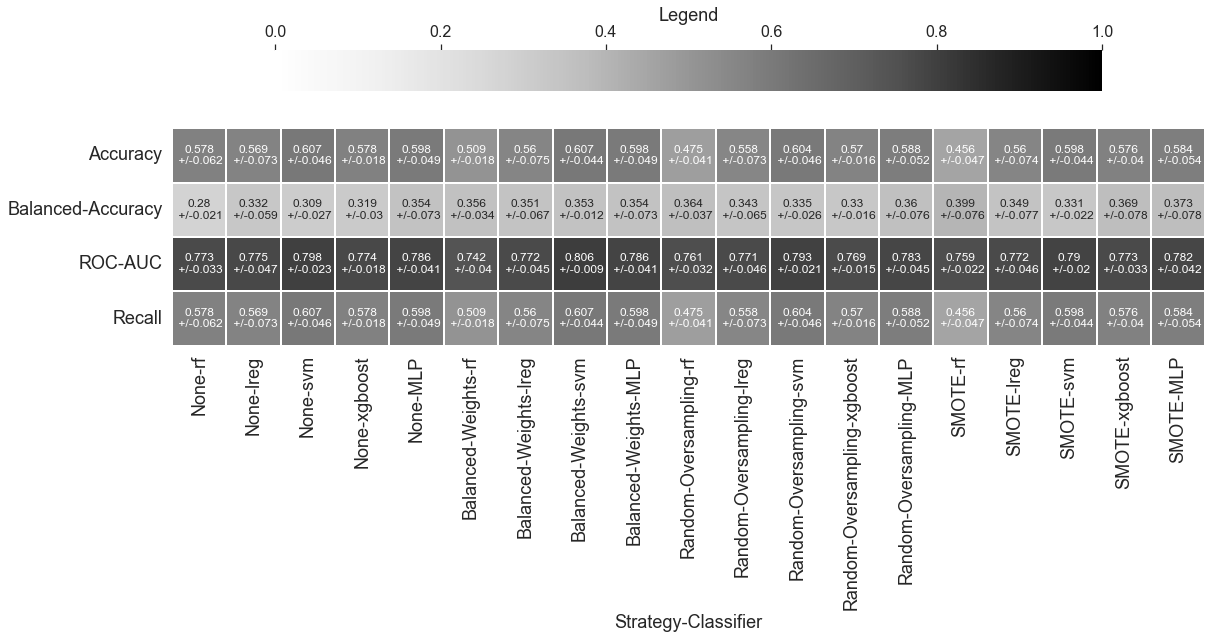

In [20]:
sns.set_theme(style="whitegrid", font_scale=1.)

fig, ax = plt.subplots(1,1, figsize=(17,11), #sharex=True
)
fig.patch.set_facecolor('#ffffff')
#plt.figure(figsize=(21,9))
g = sns.heatmap(res_table.T.drop("Random-Undersampling", axis=1), square=True, linewidth=0.05,
            cmap="Greys", vmin=0.0, vmax=1.0,
            annot = res_table_string.T.drop("Random-Undersampling", axis=1), fmt="", cbar=True,
            # annot=True, fmt=".3f", cbar=False
            cbar_kws={"orientation": "horizontal", "location": "top",
            "label":"Legend",
            "fraction": 0.1,
            #"aspect":5, 
            "shrink":0.8,
            #"anchor": (0.1, 1.1)
            },
        )

g.set(xlabel="", ylabel="", aspect="equal")
#g.despine(left=True, bottom=True)
g.set_xlabel("Strategy-Classifier", fontsize=18)
for label in g.get_yticklabels():
    label.set_fontsize(18)
for label in g.get_xticklabels():
    label.set_rotation(90)
    label.set_fontsize(18)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
ax.figure.axes[-1].xaxis.label.set_size(18)

fig.tight_layout()
#print(res.T.to_latex())
fig.savefig("../thesis/figures/results/merged/classifier_results_cv.png") #dpi=180) 

---
## CV

In [41]:
X_full = X_merged.drop(["y", "id"], axis=1)
y_full = X_merged["y"]
print(X_full.shape, y_full.shape)

(4728, 206) (4728,)


In [43]:
from sklearn.model_selection import GroupKFold

# split non-merged ids into train/val
ids_train, ids_val, y_train, y_val = train_test_split(ids, y_ids, test_size=0.3,
                                        random_state=random_state, stratify=y_ids)

X_train = X_merged[X_merged["id"].isin(ids_train)]
X_val = X_merged[X_merged["id"].isin(ids_val)]

y_train = X_train["y"]
y_val = X_val["y"]

groups = X_train.id

X_train = X_train.drop(["y", "id"], axis=1)
X_val = X_val.drop(["y", "id"], axis=1)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(groups.shape)

gkf = GroupKFold(n_splits=4)
splits = gkf.split(X_train, y_train, groups)
for trainids, testids in splits:
    print("train: ", len(dict(pd.DataFrame(y[trainids]).value_counts()).keys()))
    print(trainids[:15])
    print("test:  ", len(dict(pd.DataFrame(y[testids]).value_counts()).keys()))
    print(testids[:15])
    print()
    print()

(3279, 206) (3279,)
(1446, 206) (1446,)
(3279,)
train:  7
[58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
test:   7
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


train:  7
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
test:   7
[58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]


train:  7
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
test:   7
[102 103 104 105 106 107 108 109 110 111 112 113 114 115 116]


train:  7
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
test:   7
[144 145 146 147 148 149 150 151 152 153 154 155 156 157 158]




In [44]:
import joblib
REFITs = ["accuracy", "balanced_accuracy", "recall", "roc_auc"]
# smote+xg

results = pd.DataFrame()

for REFIT in REFITs:
    print(REFIT)
    pipe_svm = Pipeline_sampler([('scaler', StandardScaler()),
                                ('imputer', KNNImputer()),
                                ('scaler2', StandardScaler()),
                ("svc", SVC(probability=True, class_weight="balanced")),
                ])

    p_svm = {
        "svc__random_state" : [0, 42, 420, 64532],
        "svc__class_weight" : ["balanced"],
        "svc__C" : [0.01, 0.1, 0.25, 0.5, 0.75,
                    1, 1.5, 3, 5, 10,
                    15, 25, 30],
        "svc__kernel": ["rbf", "poly", "linear"],
        "svc__decision_function_shape": ["ovo"],
    }

    scoring = { 'accuracy': make_scorer(accuracy_score),
                'balanced_accuracy': make_scorer(balanced_accuracy_score),
                'f1_weighted': make_scorer(f1_score, average = 'weighted'),
                'roc_auc': make_scorer(roc_auc_score, multi_class="ovo", needs_proba=True, average="weighted"),
                'recall': make_scorer(recall_score, average = 'weighted'),
            }

    splits = gkf.split(X_train, y_train, groups)
    gscv = GridSearchCV(pipe_svm, p_svm,
        scoring=scoring, cv=splits, n_jobs=4, refit=REFIT)
    gscv.fit(X_train, y_train)
    gsres = pd.DataFrame(gscv.cv_results_)

    best_model = gscv.best_estimator_
    print(best_model)

    _roc = gsres.sort_values(by=["mean_test_roc_auc", "mean_test_balanced_accuracy"], ascending=False).round(3).iloc[0,:]["mean_test_roc_auc"]
    _roc_std = gsres.sort_values(by=["mean_test_roc_auc", "mean_test_balanced_accuracy"], ascending=False).round(3).iloc[0,:]["std_test_roc_auc"]
    print("cv-train {}: {} +/- {:.3f}".format(REFIT, _roc, _roc_std*1.96))

    if not os.path.isfile(f"models/merged/svm_{REFIT}.pkl"):
        joblib.dump(best_model, f"models/merged/svm_{REFIT}.pkl")
        joblib.dump(best_model.fit(X_full,y_full), f"models/merged/svm_{REFIT}_trained_on_all.pkl")
    else:
        best_model = joblib.load(f"models/merged/svm_{REFIT}.pkl")

accuracy
Pipeline(steps=[('scaler', StandardScaler()), ('imputer', KNNImputer()),
                ('scaler2', StandardScaler()),
                ('svc',
                 SVC(C=1, class_weight='balanced',
                     decision_function_shape='ovo', probability=True,
                     random_state=0))])
cv-train accuracy: 0.812 +/- 0.024
balanced_accuracy
Pipeline(steps=[('scaler', StandardScaler()), ('imputer', KNNImputer()),
                ('scaler2', StandardScaler()),
                ('svc',
                 SVC(C=0.1, class_weight='balanced',
                     decision_function_shape='ovo', probability=True,
                     random_state=0))])
cv-train balanced_accuracy: 0.812 +/- 0.024
recall
Pipeline(steps=[('scaler', StandardScaler()), ('imputer', KNNImputer()),
                ('scaler2', StandardScaler()),
                ('svc',
                 SVC(C=1, class_weight='balanced',
                     decision_function_shape='ovo', probability=True,
          

In [20]:
from src.ehd_classification.prediction import compute_metrics
REFITs = ["accuracy", "balanced_accuracy", "recall", "roc_auc"]

final_results = pd.DataFrame()
cms = []
for REFIT in REFITs:
    print(f"{REFIT}:    ")
    model = joblib.load(f"models/merged/svm_{REFIT}.pkl")
    #print(model)
    r1, r2, cm = compute_metrics(model, X_train, y_train, X_val, y_val, index=REFIT)
    cms.append(cm)
    final_results = final_results.append(r1)
    print(r2)
    if REFIT == "roc_auc":
        print(r2.T.to_latex())
    print("")
final_results

accuracy:    
                              0      1      2      3      4    6      7
TPR-Sensitivity (recall)  0.839  0.000  0.065  0.508  0.342  0.0  0.703
TNR-Specificity           0.719  0.995  0.983  0.944  0.988  1.0  0.856

balanced_accuracy:    
                              0      1      2      3      4    6      7
TPR-Sensitivity (recall)  0.653  0.045  0.130  0.336  0.789  0.0  0.546
TNR-Specificity           0.870  0.990  0.896  0.923  0.850  1.0  0.833

recall:    
                              0      1      2      3      4    6      7
TPR-Sensitivity (recall)  0.839  0.000  0.065  0.508  0.342  0.0  0.703
TNR-Specificity           0.719  0.995  0.983  0.944  0.988  1.0  0.856

roc_auc:    
                              0      1      2      3      4    6      7
TPR-Sensitivity (recall)  0.705  0.000  0.087  0.413  0.632  0.0  0.662
TNR-Specificity           0.839  0.989  0.936  0.928  0.938  1.0  0.785
\begin{tabular}{lrr}
\toprule
{} &  TPR-Sensitivity (recall) &  TNR-Spe

,F1,Accuracy,Balanced Accuracy,Recall,ROC-AUC
accuracy,0.612,0.624,0.351,0.624,0.786
balanced_accuracy,0.509,0.480,0.357,0.480,0.766
recall,0.612,0.624,0.351,0.624,0.786
roc_auc,0.555,0.548,0.357,0.548,0.785


In [169]:
print(cms[0])

     0  1  2    3   4  6    7
0  338  4  6   27   4  0   24
1    9  0  2    1   0  0   10
2   28  0  3    9   1  0    5
3  151  3  6  271   3  0   99
4   13  0  0    0  13  0   12
6    2  0  4    2   0  0    2
7   90  0  6   12   9  0  277


In [174]:
print(cms[0])

     0  1  2    3   4  6    7
0  338  4  6   27   4  0   24
1    9  0  2    1   0  0   10
2   28  0  3    9   1  0    5
3  151  3  6  271   3  0   99
4   13  0  0    0  13  0   12
6    2  0  4    2   0  0    2
7   90  0  6   12   9  0  277


In [175]:
print(cms[1])

     0  1  2    3   4  6    7
0  338  4  6   27   4  0   24
1    9  0  2    1   0  0   10
2   28  0  3    9   1  0    5
3  151  3  6  271   3  0   99
4   13  0  0    0  13  0   12
6    2  0  4    2   0  0    2
7   90  0  6   12   9  0  277


In [176]:
print(cms[2])

     0  1  2    3   4  6    7
0  338  4  6   27   4  0   24
1    9  0  2    1   0  0   10
2   28  0  3    9   1  0    5
3  151  3  6  271   3  0   99
4   13  0  0    0  13  0   12
6    2  0  4    2   0  0    2
7   90  0  6   12   9  0  277


In [21]:
print(cms[3])

_cm = cms[3]

_cm.columns = ['Hospitalized',
        'Vent', 'ICU', 'ICU + Vent.',
        'Deceased', 'Deceased + ICU',
        'Deceased + ICU + Vent.']
_cm.index = ['Hospitalized',
        'Vent', 'ICU', 'ICU + Vent.',
        'Deceased', 'Deceased + ICU',
        'Deceased + ICU + Vent.']
_cm.to_markdown()

     0  1   2    3   4  6    7
0  284  7  34   26  24  0   28
1    8  0   3    2   0  0    9
2   18  1   4    7  10  0    6
3   89  7  30  220  14  0  173
4    7  0   0    0  24  0    7
6    2  0   4    0   1  0    3
7   44  0  19   31  39  0  261


'|                        |   Hospitalized |   Vent |   ICU |   ICU + Vent. |   Deceased |   Deceased + ICU |   Deceased + ICU + Vent. |\n|:-----------------------|---------------:|-------:|------:|--------------:|-----------:|-----------------:|-------------------------:|\n| Hospitalized           |            284 |      7 |    34 |            26 |         24 |                0 |                       28 |\n| Vent                   |              8 |      0 |     3 |             2 |          0 |                0 |                        9 |\n| ICU                    |             18 |      1 |     4 |             7 |         10 |                0 |                        6 |\n| ICU + Vent.            |             89 |      7 |    30 |           220 |         14 |                0 |                      173 |\n| Deceased               |              7 |      0 |     0 |             0 |         24 |                0 |                        7 |\n| Deceased + ICU         |              

In [180]:
np.equal(cms[0], cms[1])

,0,1,2,3,4,6,7
0,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True
6,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True
